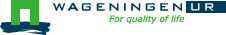



# Running crop rotations with PCSE/WOFOST

This Jupyter notebook will demonstrate how to run crop rotations with PCSE/WOFOST.

Allard de Wit, March 2018

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts
 
Finally you need an internet connection to obtain data from internet resources


## Importing the relevant modules


In [1]:
%matplotlib inline
import sys, os
current_dir = os.getcwd()

import pandas as pd
import yaml
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.fileinput import YAMLCropDataProvider, YAMLAgroManagementReader, ExcelWeatherDataProvider, CABOFileReader
from pcse.util import WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.models import Wofost71_WLP_FD

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.4.2


## Defining the agromanagement
Implementing a crop rotation involves simulating two or more crops sequentially in a single run. This implies that the agromanagement details of the crop must be specified in a sequential way. In a PCSE agromanagement definition this can accomplished by specifying a series of campaigns, each with a crop calendar and possible events. Below is an example of a PCSE agromanagement definition with three campaigns: the first for winter-wheat, the second does not have a crop defined (e.g. fallow) and during the last campaign a sugar beets are cultivated. for a thorough discusion on agromanagement have a look at the [Section on Agromanagement](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-agromanager) in the PCSE manual.

Usually, the crops in the rotation are different crop types which is good agricultural practice done to avoid pest, disease and exhausting the soil. Therefore, a key difference with the previous notebooks is that we now have to provide multiple sets of crop parameters in order to parameterize the crop simulation model for the different campaigns. The example below requires crop parameters for wheat and sugar beet in order to run the simulations.

Providing multiple sets of crop parameters cannot be accomplished using a simple crop parameter file (e.g. a WOFOST CABO file) because PCSE does not have a way to access different parameter files during the simulation run. Instead, a special class of data providers has been created that can hold and serve parameter sets for multiple crops and varieties: the `MultiCropDataProvider`.


In [2]:
agro_yaml = """
AgroManagement:
- 2006-08-01:
    CropCalendar:
        crop_name: wheat
        variety_name: Winter_wheat_101
        crop_start_date: 2006-09-15
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- 2007-09-01:
    CropCalendar: null
    TimedEvents: null
    StateEvents: null
- 2008-03-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2008-04-15
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 200
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml)

## The YAMLCropDataProvider

Currently, PCSE only provides one `MultiCropDataProvider` which is the `YAMLCropDataProvider`. This data provider reads the crop parameters from files in a [dedicated YAML structure](https://github.com/ajwdewit/WOFOST_crop_parameters) and holds them in memory. Below, we will explain the details and usage of the `YAMLCropDataProvider`.

The YAMLCropDataProvider reads the entire set of crop parameters available for all crops in WOFOST, including the varieties that are defined for each crop. Starting the YAMLCropDataProvider without any inputs will make it read the crop parameter files from a github repository, but it can be pointed to a location on the file system as well.

After loading the crop parameter files, there is no active crop/variety so no parameters are printed. 

In [3]:
cropd = YAMLCropDataProvider()
print(cropd)

YAMLCropDataProvider - crop and variety not set: no activate crop parameter set!



Printing the available crops/varieties can be done by calling `print_crops_varieties()` and a particular crop/variety can be activitated using `set_active_crop("<crop_name>", "<variety_name>")`. Note that `crop_name`  and `variety_name` are case sensitive and should exactly match the selected crop/variety. After setting the activate crop, the available crop parameters can be viewed by printing the contents.

In [4]:
#cropd.print_crops_varieties()
cropd.set_active_crop("wheat", "Winter_wheat_101")
print(cropd)

YAMLCropDataProvider - current active crop 'wheat' with variety 'Winter_wheat_101'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 0.0, 'TEFFMX': 30.0, 'TSUMEM': 120, 'IDSL': 2, 'DLO': 16.8, 'DLC': 8.0, 'TSUM1': 543, 'TSUM2': 1194, 'DTSMTB': [0.0, 0.0, 30.0, 30.0, 45.0, 30.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 10.0, 'VERNSAT': 49.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 50.0, 'RGRLAI': 0.0082, 'SLATB': [0.0, 0.00212, 0.5, 0.00212, 2.0, 0.00212], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 31.3, 'TBASE': 0.0, 'KDIFTB': [0.0, 0.6, 2.0, 0.6], 'EFFTB': [0.0, 0.45, 40.0, 0.45], 'AMAXTB': [0.0, 35.83, 1.0, 35.83, 1.3, 35.83, 2.0, 4.48], 'TMPFTB': [0.0, 0.01, 10.0, 0.6, 15.0, 1.0, 25.0, 1.0, 35.0, 0.0

## Linking Agromanagement with the YAMLCropDataProvider
For running crop rotations a link must be created between the crops defined in the agromanagement and the available crops/varieties in the YAML parameter files. This link is created through the `crop_name` and `variety_name` keywords in the agromanagement which should *exactly* match the crop_name and variety_name in the YAMLCropDataProvider.

Through the `crop_name` and `variety_name` keywords, the agromanager can instruct the simulation engine to change the set of active crop_parameters before a crop is started allowing a different crop to be simulated within a single run.

## Simulating the example above

We will make a water-limited simulation with WOFOST using the agromanagement sequence defined above. For starting the simulation we need to prepare the other inputs (weather data, soil parameters and site parameters) as was already demonstrated in other notebooks.

In [5]:
weather_fname = os.path.join(current_dir, "data", "meteo", "nl1.xlsx")
wdp = ExcelWeatherDataProvider(weather_fname)
soil_fname = os.path.join(current_dir, "data", "soil", "ec3.soil")
soild = CABOFileReader(soil_fname)
sited = WOFOST71SiteDataProvider(WAV=10)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [6]:
wofost = Wofost71_WLP_FD(params, wdp, agro)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

## Visualizing the results

The figures below show the simulated leaf area index, total aboveground production, total weight storage organs (yield) and the volumetric soil moistures content. The figures related the crop biomass and leaf area index clear demonstrate the two crop cycles and the fallow period in between. In contrast the soil moisture is simulated continuously demonstrating that that the simulation consists of a single run with two individual crop types.

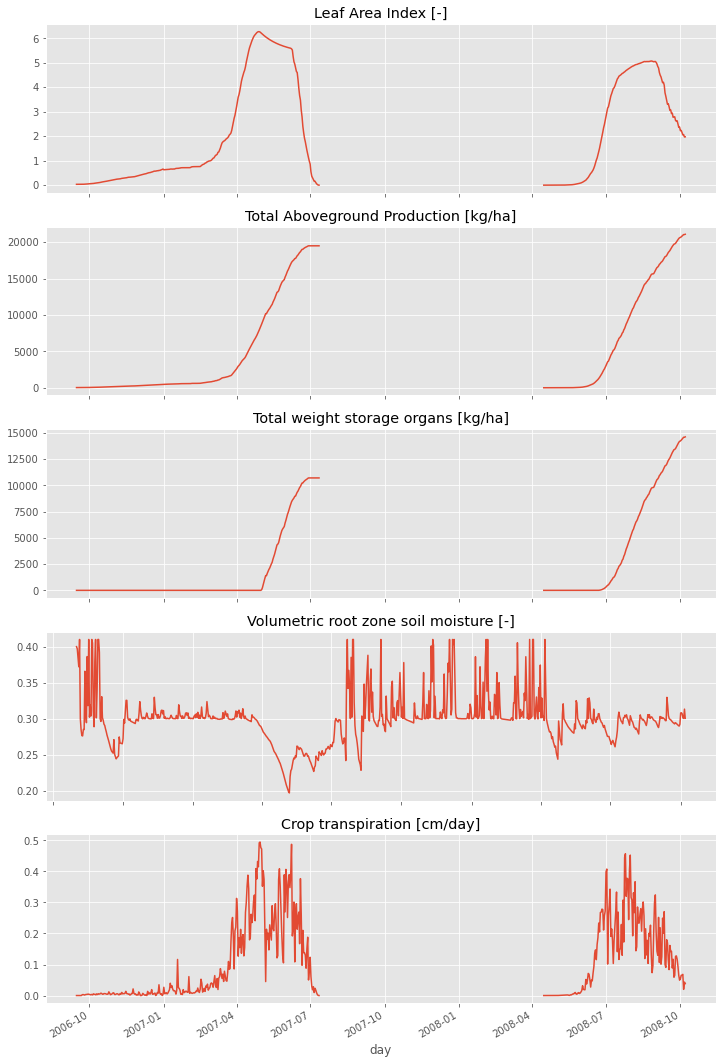

In [7]:
plot_variables = [("LAI", "Leaf Area Index [-]"), 
                  ("TAGP", "Total Aboveground Production [kg/ha]"), 
                  ("TWSO", "Total weight storage organs [kg/ha]"), 
                  ("SM", "Volumetric root zone soil moisture [-]"),
                  ("TRA","Crop transpiration [cm/day]")]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,20))
for (varname, vartitle), ax in zip(plot_variables, axes):
    df[varname].plot(ax=ax, title=vartitle)
fig.autofmt_xdate()